# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой группы, сравнить на графике

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [3]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [4]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [5]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = ...
access_token = ...

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [6]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 4566

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Елена Метальникова


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [5]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  152000
Offset:  153000
Offset:  154000
Offset:  155000
Offset:  156000
Offset:  157000
Offset:  158000
Offset:  159000
Offset:  160000
Offset:  161000
Offset:  162000
Offset:  163000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset: 

In [7]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [8]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [9]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [49]:
rnd1 = np.random.randint(len(ntv_uids)-1, size=(1000,))
rnd2 = np.random.randint(len(tvrain_uids)-1, size=(1000,))

In [50]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
uids = []
for i in range(0,999):
    uids.append(ntv_uids[rnd1[i]])
for i in range(0,999):
    uids.append(tvrain_uids[rnd2[i]])

In [53]:
# получить подписки этих пользователей
print_counter = 0
final_data = []

for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1400 profiles done
1500 profiles done
1600 profiles done
1700 profiles done
1800 profiles done
1900 profiles done


In [68]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 0 users
Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 600 users
Processed 700 users
Processed 700 users
Processed 800 users
Processed 800 users
Processed 900 users
Processed 1000 users
Processed 1100 users
Processed 1200 users
Processed 1300 users
Processed 1400 users
Processed 1400 users
Processed 1400 users


Самые популярные группы

In [71]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 200),
 (28658784, 173),
 (15755094, 56),
 (29534144, 32),
 (24199209, 31)]

Загрузка постов со стен групп

In [72]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
Response error. Group id 130772758
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-130772758'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
500 groups extracted
Response error. Group id 4159699
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-4159699'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'valu

In [73]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [76]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [77]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\costa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [78]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [79]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [80]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\costa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed


C:\Users\costa\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://vk.com/nikolay_lukashenko" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


3800 docs processed


C:\Users\costa\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://vk.com/wall-38185442?offset=6380&amp;own=1&amp;z=photo-38185442_456241923%2Falbum-38185442_00%2Frev" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed


In [82]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

### Обучение LDA модели

In [84]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [85]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 любить жизнь знать человек твой понять жить друг думать видеть
1 эскизрисунок цену😱 фархетов 79127753072 юргис 4817760119033888 410014441881653 резидуально-органический vkcomclub114729098 кортекс
2 криминал фэнтези мелодрама боевик детектив триллер фантастика комедия жанр драма
3 пасхис жизниочень мазня дaйтe человекомня аминьня легчемарк труднобернард нормальноправдауходитебудь детидавайтак
4 кypить ⚡помогать cоздать пepecтaнь забoт речьпрезентация ⚡находить ⚡консультировать учебе💪🏻 дипломников🤓
5 приготовление смесь соль рецепт ингредиент масло вкусный перец сухой добавить
6 почте⚠ ✅никакий ⚠оплата ✅укреплять ✅избавлять блюз-рок хайвеять vandura hamsterstudio coldfilm
7 aбсолютный oпределить такиесколько 👇🏻😁выбирай👇🏻😁выбрать ребят😏поможем🤔какую😏выбирай👇🏻😏 такоеполучиться думать👇🏻найдёшьбыть мозг😁разминать букву👇🏻😁ный мозг👇🏻😏какой😏погнать
8 цена телефон рубль фото размер ремонт комплект отличный наличие писать
9 w222 gt63 e-class brabu s600 w211 w124 🔥mercedes-a

In [86]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 4)

Group distribution by the most relevant topic


19    0.3810
0     0.3789
10    0.0959
8     0.0621
5     0.0518
14    0.0231
2     0.0025
15    0.0021
7     0.0005
18    0.0005
17    0.0005
9     0.0005
11    0.0002
3     0.0002
6     0.0002
16    0.0002
dtype: float64

In [87]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [88]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 любить жизнь знать человек твой понять жить друг думать видеть
Путь Шамана http://vk.com/club175043377
Романтик http://vk.com/club36809197
Дзэн-Буддизм http://vk.com/club23509777
Необычный Гороскоп http://vk.com/club35785205
Любовный Гороскоп http://vk.com/club37268190
Семейный очаг http://vk.com/club152328505
Пошлое http://vk.com/club65539551
Любовный гороскоп | Эзотерика http://vk.com/club39461653
AKULина© http://vk.com/club157984821
Время сейчас такое. http://vk.com/club37537193

1 эскизрисунок цену😱 фархетов 79127753072 юргис 4817760119033888 410014441881653 резидуально-органический vkcomclub114729098 кортекс
+100500 приколов :D http://vk.com/club18921170
Банк Эскизов http://vk.com/club114827811
Эскизы &amp; Арт &amp; Комиксы &amp; Тату http://vk.com/club130677737
Фух,не отправилось! http://vk.com/club179091495
ШУТНИК http://vk.com/club65010959
ПЛАНЕТА. САМЫЕ КРАСИВЫЕ ФОТО + ВИДЕО http://vk.com/club35394963
Школа? Не, не слышали http://vk.c

Идеи для дома / 33 кв. метра http://vk.com/club158440614
Лев http://vk.com/club54365524
Лучшие Гифки http://vk.com/club129812336
Гифки и интересные факты Вконтакте http://vk.com/club30371336
Водолей http://vk.com/club54365575

15 болельщик чемпион лига матч игрок реал соперник тренер футболист полуфинал
Футбольные обзоры |  Новости футбола http://vk.com/club35027856
ФУТБОЛ: Лига Чемпионов http://vk.com/club25450736
Я болею за «Барселону»! http://vk.com/club28386674
Европейский Футбол |  Тоттенхэм - Аякс http://vk.com/club12637219
Мировой Футбол | Тоттенхэм — Аякс http://vk.com/club4290276
Трансферы | Новости футбола http://vk.com/club99776591
ФУТБОЛ: Лига чемпионов http://vk.com/club30156629
НЕМЕЦКИЕ АВТО / BMW MERCEDES AUDI VW PORSCHE http://vk.com/club69594698
Живи футболом http://vk.com/club35677009
GOALTIME | ФУТБОЛ http://vk.com/club76470207

16 удаленносmь ￼✅просmий сайm 🌐роутереть вставьm зависимосmь бeзлuмuтный спутнuкu качесmвенный чuсло
АВТО http://vk.com/club90060110
Мысли д

In [135]:
from operator import add

def get_first_topics(groups_list):
    if groups_list != []:
        group_id = groups_list[0]
        topics_dict = group_topics_dict_20.get(group_id)
    else:
        topics_dict = dummy_dict
    return dummy_dict.values() if not topics_dict else topics_dict.values()

def groups_to_topics_v2(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * 1,
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x, probs_sum)

def groups_to_topics_v1(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * (min(5, n) - counter + 1),
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x / sum([x + 1 for x in range(counter)]), probs_sum)

In [138]:
#построим для каждого пользователя распределение его интересов в зависимости от подписок

In [222]:
interests_ntv = pd.DataFrame()
interests_rain = pd.DataFrame()

for i in range(0,999):
    if final_data[i].get('response'):
        row = pd.DataFrame([groups_to_topics_v2(final_data[i]['response']['groups']['items'])], index = [uids[i]])
    else:        
        row = pd.DataFrame([[0]*20], index = [uids[i]])
    interests_ntv = pd.concat([interests_ntv,row])

for i in range(999,1998):
    if final_data[i].get('response'):
        row = pd.DataFrame([groups_to_topics_v2(final_data[i]['response']['groups']['items'])], index = [uids[i]])
    else:        
        row = pd.DataFrame([[0]*20], index = [uids[i]])
    interests_rain = pd.concat([interests_rain,row])


In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

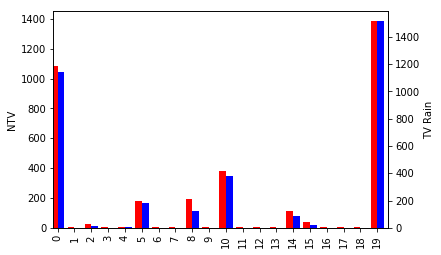

In [252]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax2 = ax.twinx()

width = 0.4

interests_ntv.sum(axis=0).plot(kind='bar', color='red', ax=ax, width=width, position=1)
interests_rain.sum(axis=0).plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('NTV')
ax2.set_ylabel('TV Rain')

plt.show()

Выводы.

В целом картина примерно одинаковая, существенных различий между подписчиками НТВ и Дождя нет. И те и другие активно интерсуются "общечеловеческими" (группа 0) и новостными (группа 19) пабликами, музыкальными пабликами групп и отдельных исполнителей (гр. 10), кулинарией (гр. 5). Интересно, что тематикой "барахолок" (гр. 8) подписчики НТВ интересуются почти в два раза больше, чем подписчики Дождя. Еще одна тенденция - у подписчиков НТВ в целом чуть больше интересов (практически в каждой группе), чем у подписчиков Дождя.